# Bikes

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
from scipy.stats import pearsonr

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
bikes = pd.read_csv("bikes.csv")

X = bikes[["hour", "temperature", "humidity", "windspeed"]]
Y = bikes["count"]

ordered_var_names = ["hour", "temperature", "humidity", "windspeed"]

### With default m=50

In [4]:
# With m=50
idatas_m50 = []
trees_m50 = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", Y.std())
        μ = pmb.BART("μ", X[ordered_var_names[: idx + 1]], Y, m=50)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata = pm.sample(chains=4, random_seed=RANDOM_SEED)
        idatas_m50.append(idata)
        trees_m50.append(μ)

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


We now check that computing the predictions estimated by pruning the trees is close to the predictions if we actually ommits covariables and refit models

In [5]:
samples = 100
rng = np.random.default_rng(RANDOM_SEED)

In [6]:
predicted_all = pmb.utils._sample_posterior(
    trees_m50[-1].owner.op.all_trees, X=X.values, rng=rng, size=samples
)
ev_mean = np.zeros(len(ordered_var_names))
ev_hdi = np.zeros((len(ordered_var_names), 2))

for idx, tree in enumerate(trees_m50):
    predicted_subset = pmb.utils._sample_posterior(
        tree.owner.op.all_trees,
        X=X[ordered_var_names[: idx + 1]].values,
        rng=rng,
        size=samples,
    )
    pearson = np.zeros(samples)
    for j in range(samples):
        pearson[j] = (
            pearsonr(predicted_all[j].flatten(), predicted_subset[j].flatten())[0]
        ) ** 2
    ev_mean[idx] = np.mean(pearson)
    ev_hdi[idx] = az.hdi(pearson)

<ErrorbarContainer object of 3 artists>

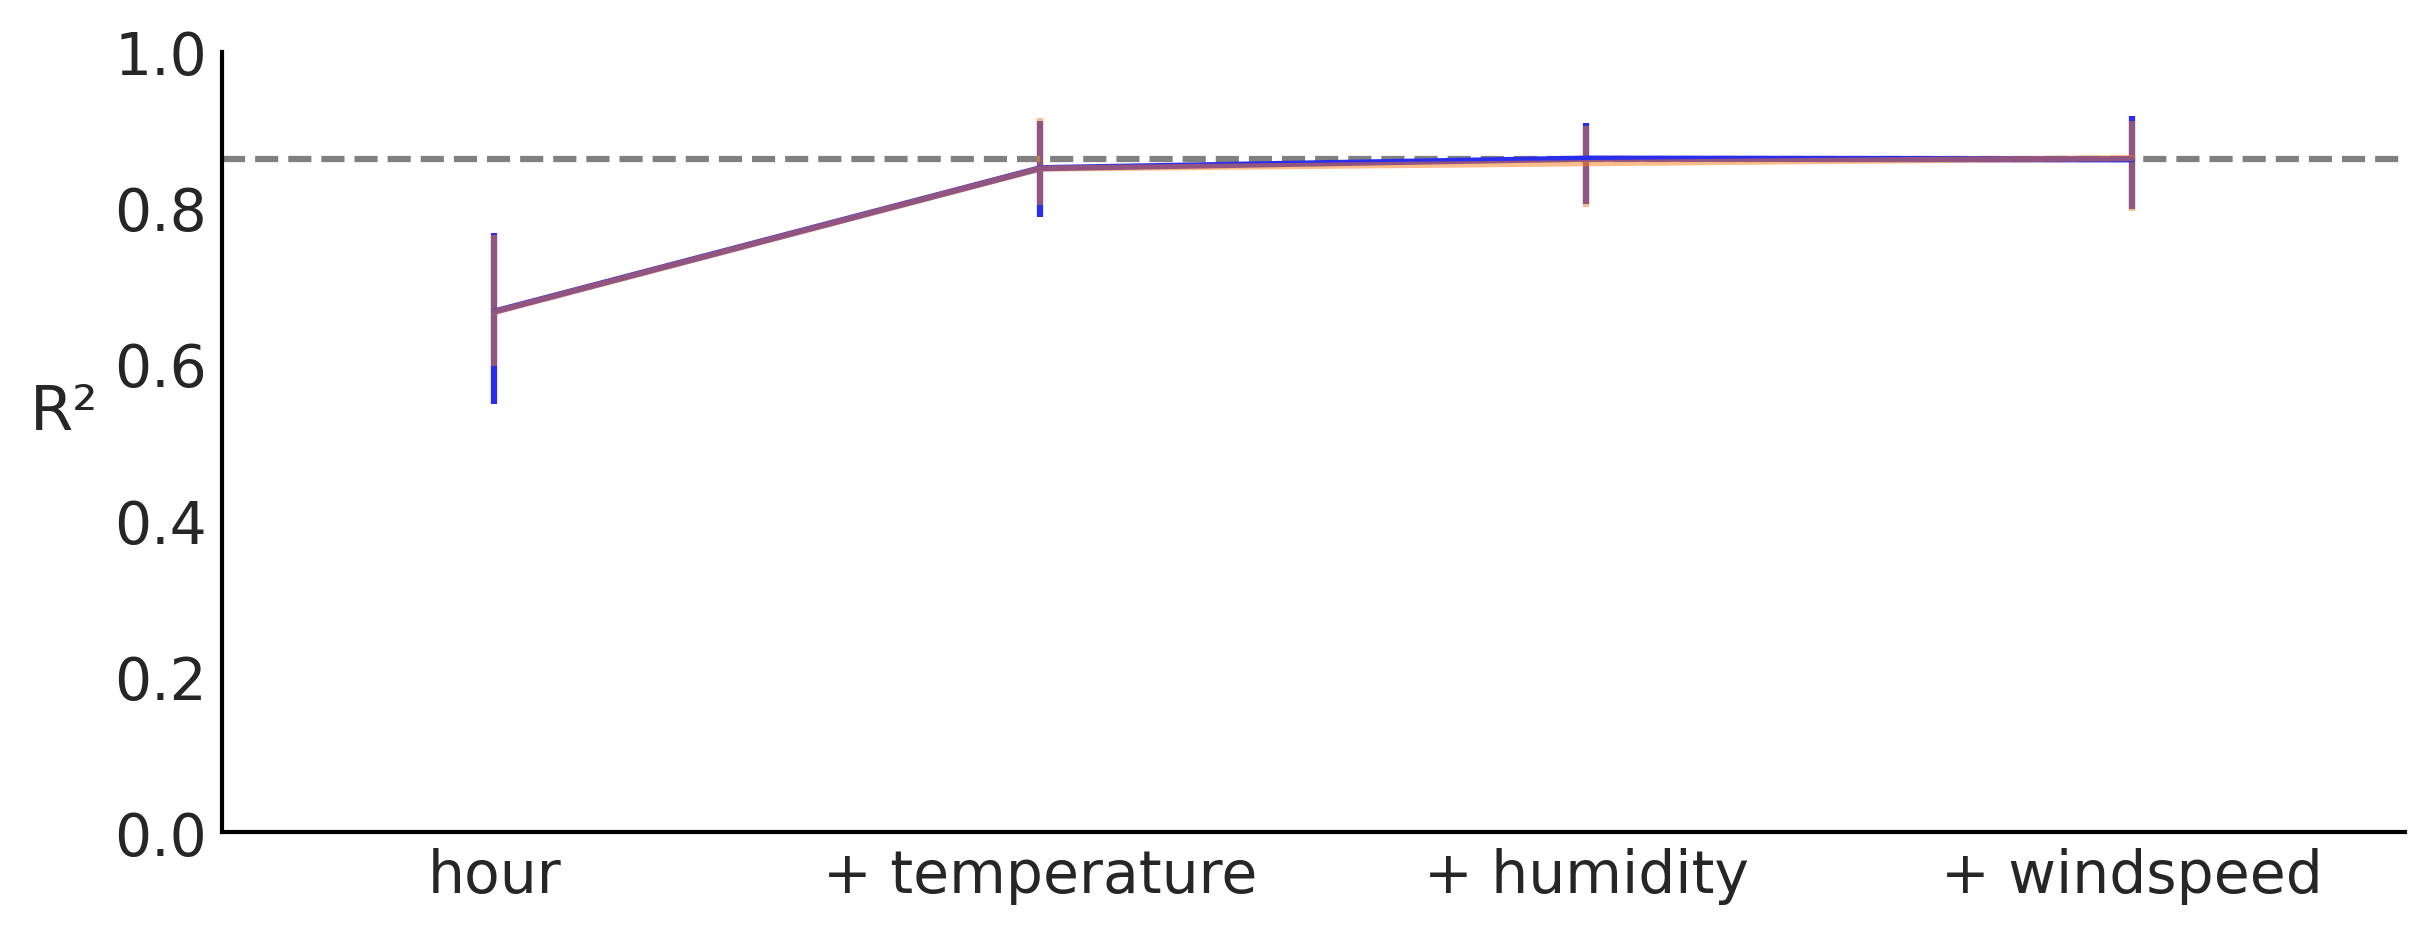

In [8]:
axes = pmb.plot_variable_importance(
    idatas_m50[-1], trees_m50[-1], X.values, labels=ordered_var_names, samples=samples
)

ticks = np.arange(len(ordered_var_names), dtype=int)
plt.errorbar(
    ticks,
    ev_mean,
    np.array((ev_mean - ev_hdi[:, 0], ev_hdi[:, 1] - ev_mean)),
    color="C1",
    alpha=0.5,
)
# plt.savefig("bikes_VI_m50.png");

<ErrorbarContainer object of 3 artists>

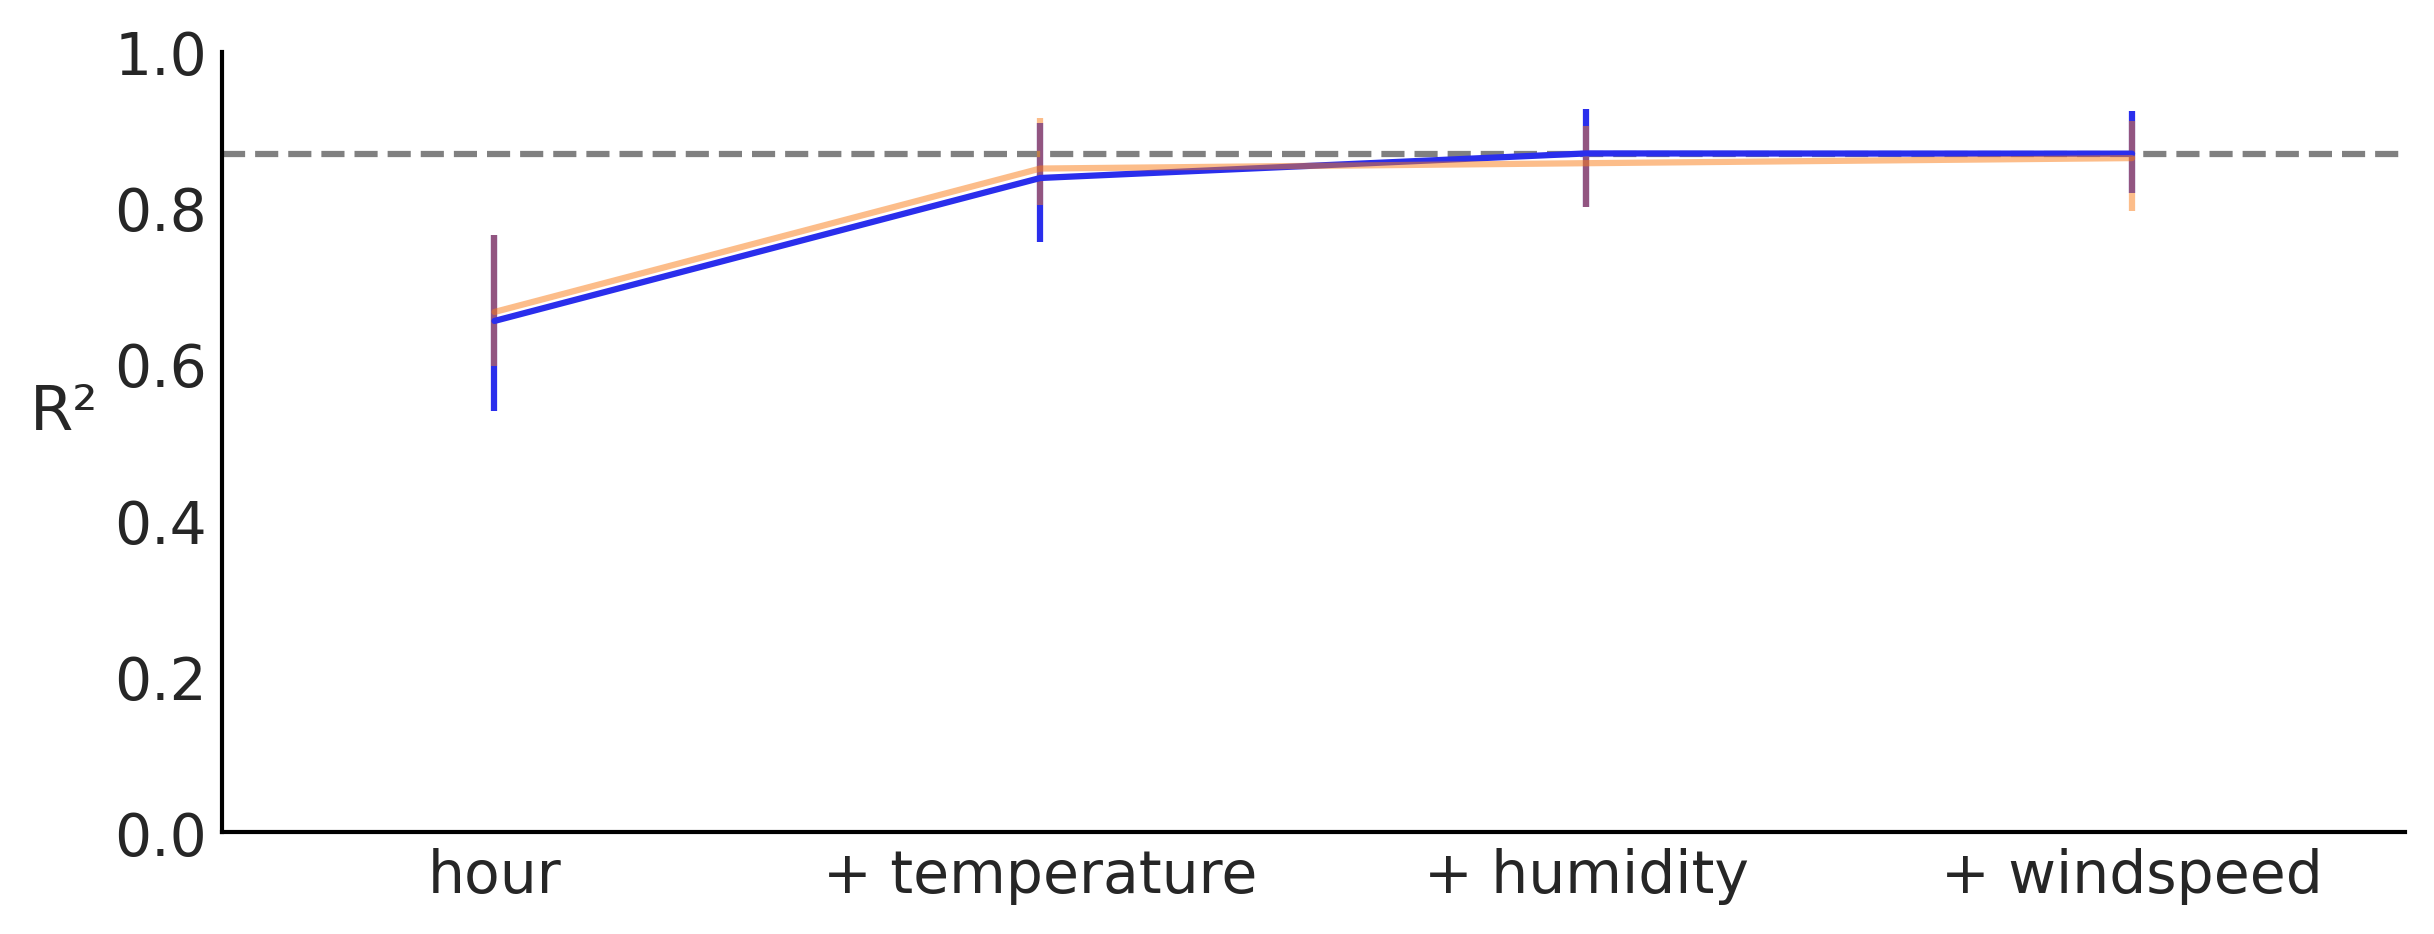

In [9]:
axes = pmb.plot_variable_importance(
    idatas_m50[-1],
    trees_m50[-1],
    X.values,
    labels=ordered_var_names,
    samples=samples,
    method="backward",
)

ticks = np.arange(len(ordered_var_names), dtype=int)
plt.errorbar(
    ticks,
    ev_mean,
    np.array((ev_mean - ev_hdi[:, 0], ev_hdi[:, 1] - ev_mean)),
    color="C1",
    alpha=0.5,
)

### With m=200

In [10]:
idatas_m200 = []
trees_m200 = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", Y.std())
        μ = pmb.BART("μ", X[ordered_var_names[: idx + 1]], Y, m=200)
        y = pm.Normal("y", μ, σ, observed=Y)
        idata = pm.sample(chains=4, random_seed=RANDOM_SEED)
        idatas_m200.append(idata)
        trees_m200.append(μ)

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 309 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 302 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 301 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 302 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [11]:
predicted_all = pmb.utils._sample_posterior(
    trees_m200[-1].owner.op.all_trees, X=X.values, rng=rng, size=samples
)
ev_mean = np.zeros(len(ordered_var_names))
ev_hdi = np.zeros((len(ordered_var_names), 2))

for idx, tree in enumerate(trees_m200):
    predicted_subset = pmb.utils._sample_posterior(
        tree.owner.op.all_trees,
        X=X[ordered_var_names[: idx + 1]].values,
        rng=rng,
        size=samples,
    )
    pearson = np.zeros(samples)
    for j in range(samples):
        pearson[j] = (
            pearsonr(predicted_all[j].flatten(), predicted_subset[j].flatten())[0]
        ) ** 2
    ev_mean[idx] = np.mean(pearson)
    ev_hdi[idx] = az.hdi(pearson)

<ErrorbarContainer object of 3 artists>

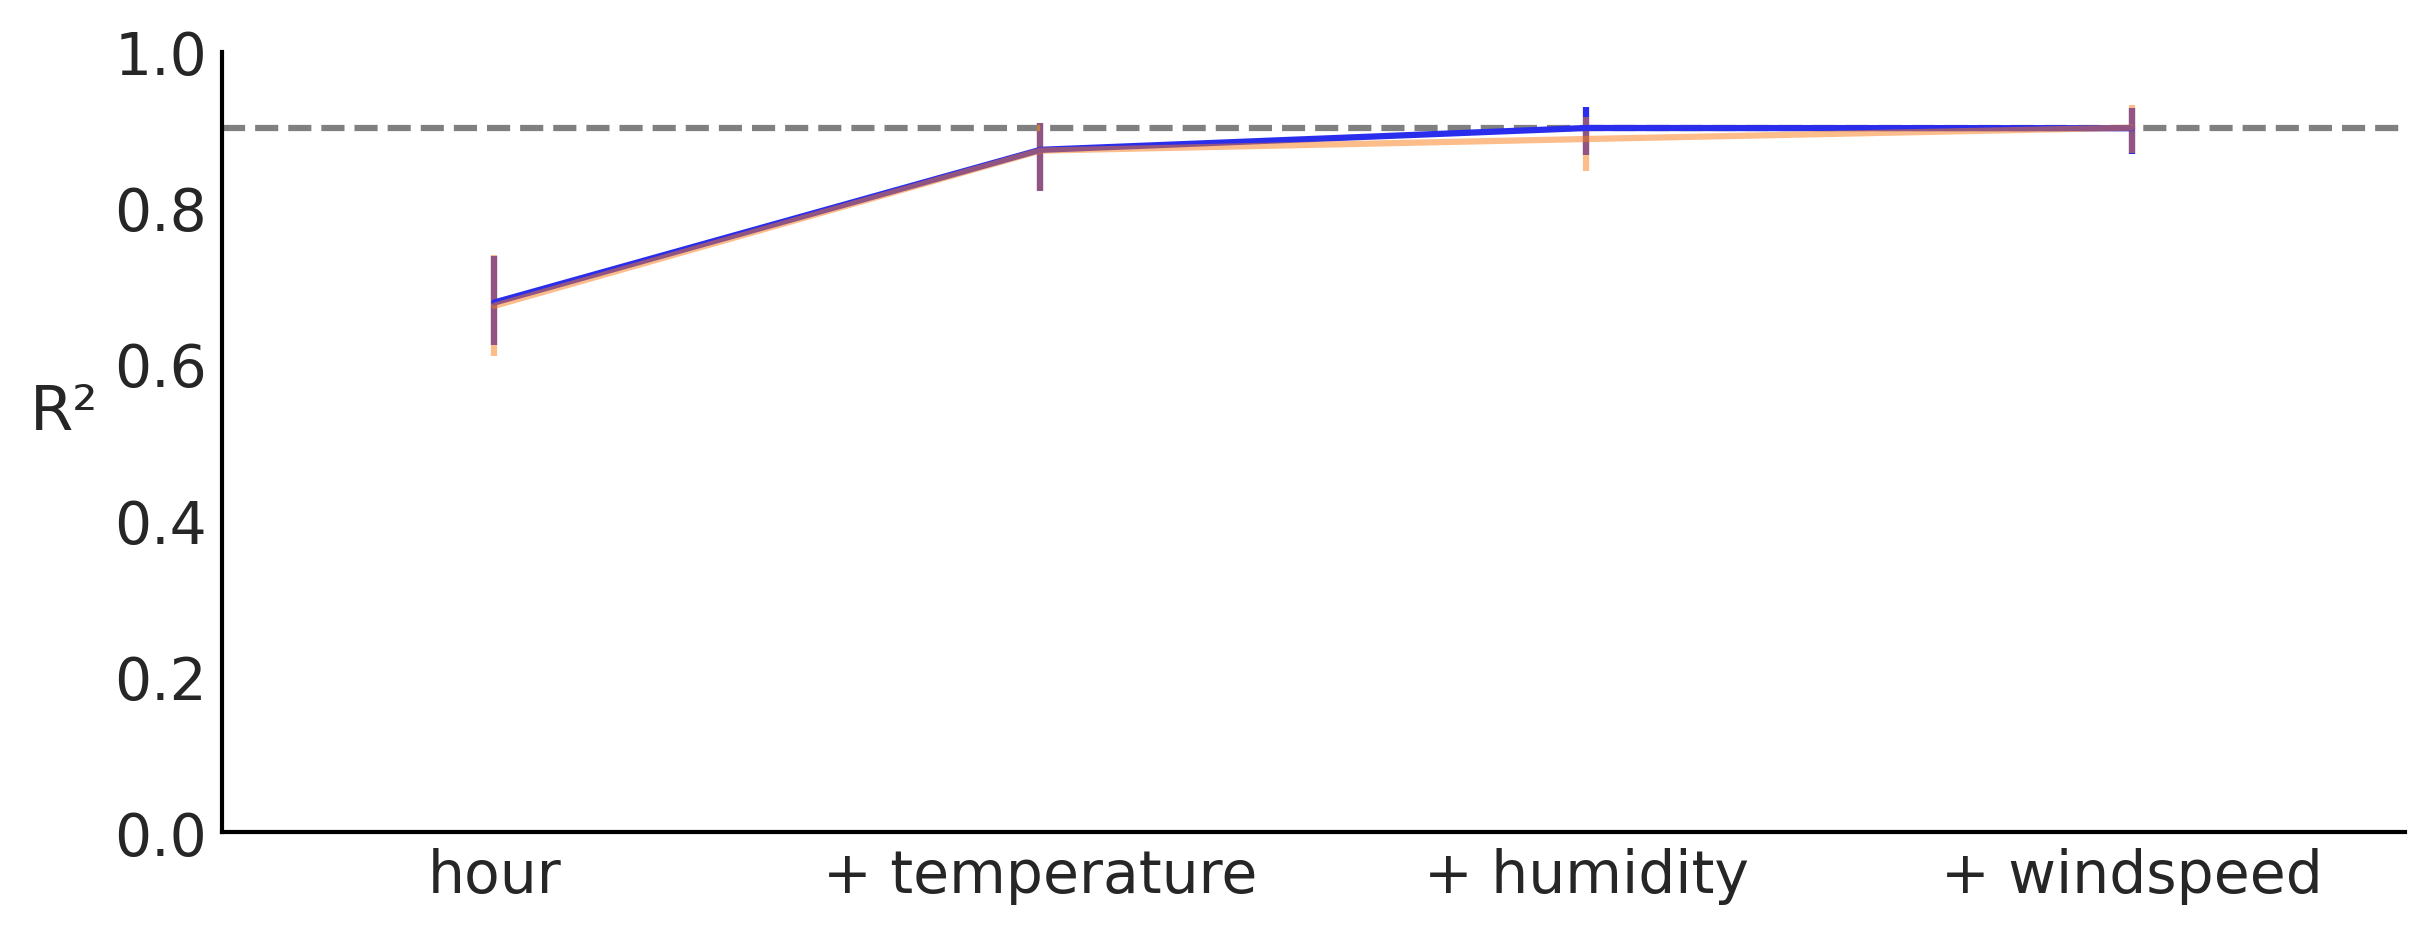

In [12]:
axes = pmb.plot_variable_importance(
    idatas_m200[-1], trees_m200[-1], X.values, labels=ordered_var_names, samples=samples
)

ticks = np.arange(len(ordered_var_names), dtype=int)
plt.errorbar(
    ticks,
    ev_mean,
    np.array((ev_mean - ev_hdi[:, 0], ev_hdi[:, 1] - ev_mean)),
    color="C1",
    alpha=0.5,
)
# plt.savefig("bikes_VI_m200.png");

<ErrorbarContainer object of 3 artists>

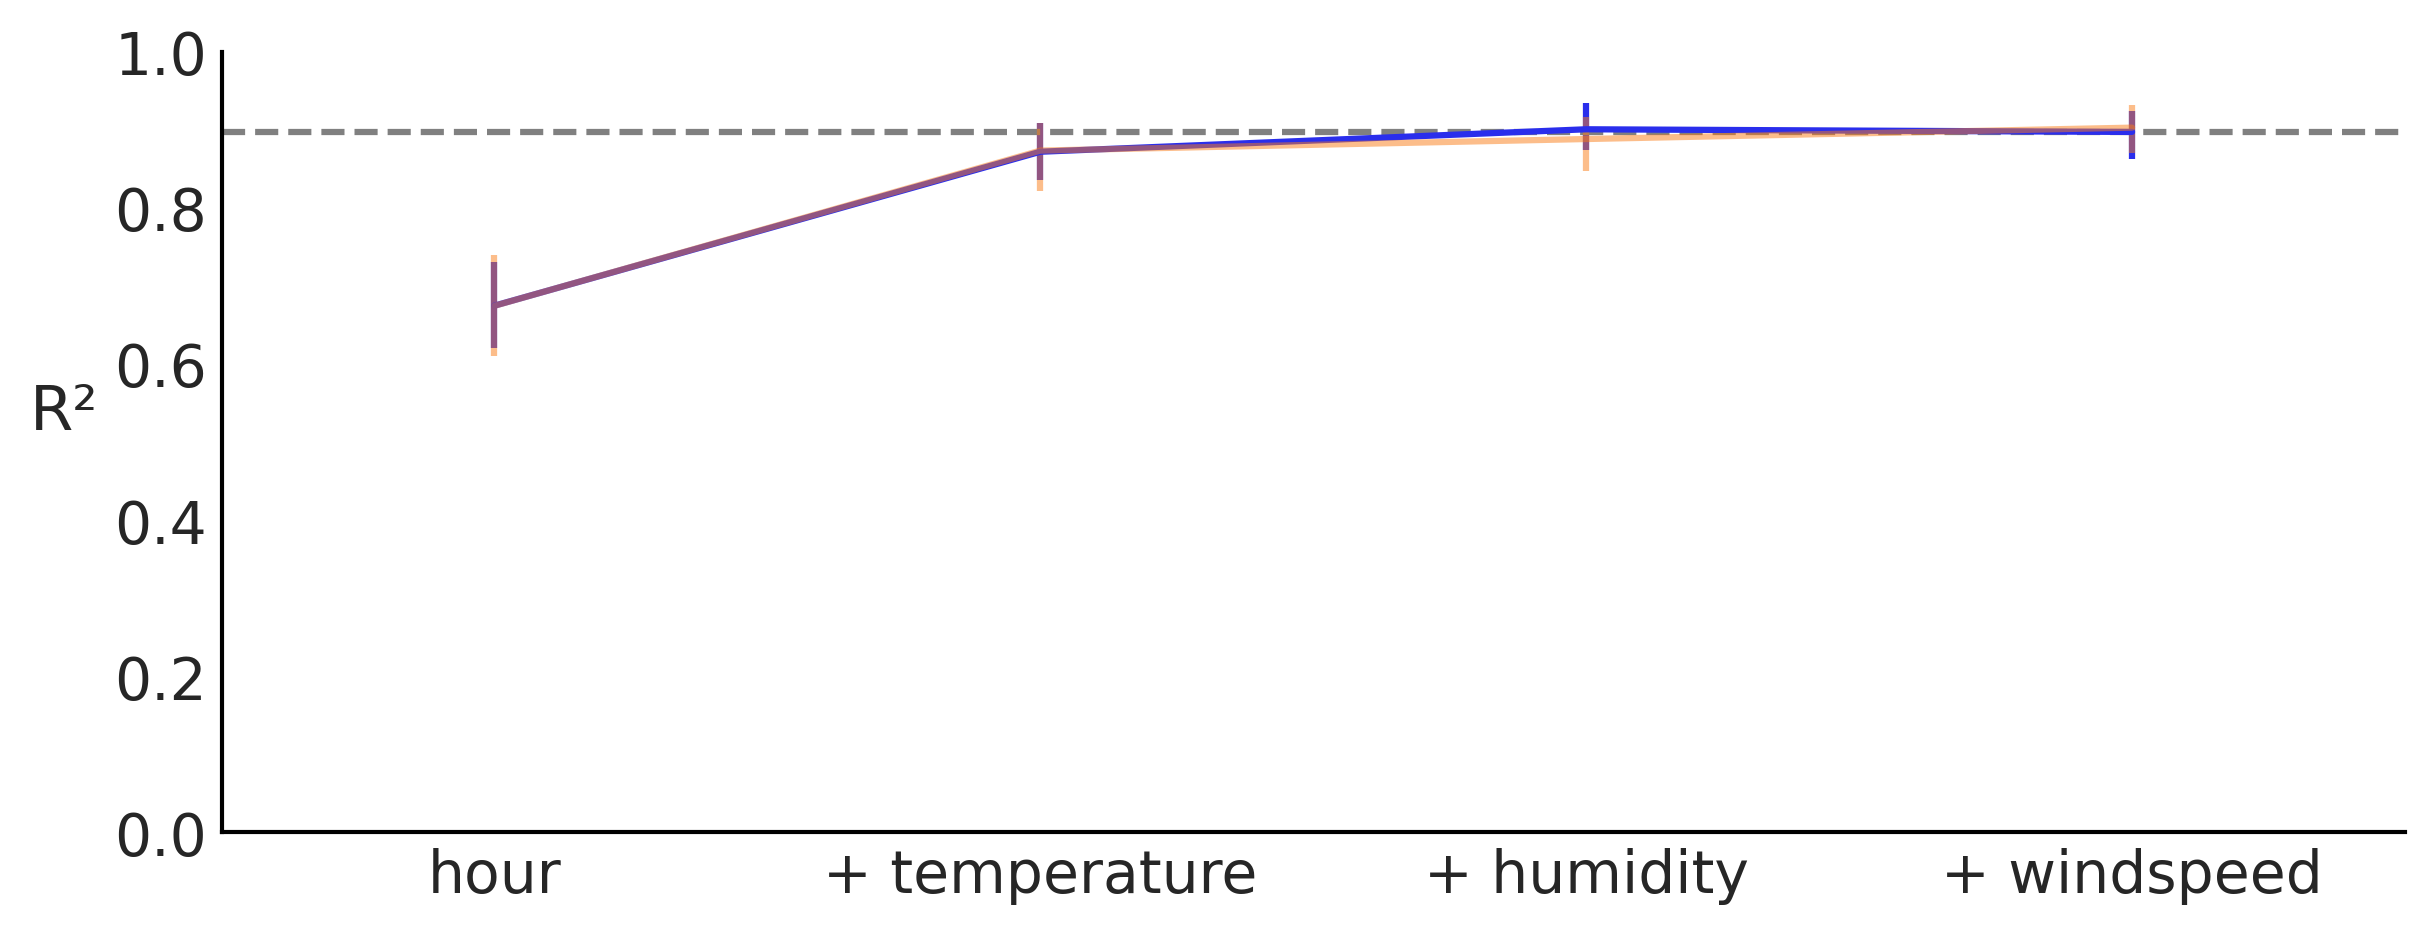

In [13]:
axes = pmb.plot_variable_importance(
    idatas_m200[-1],
    trees_m200[-1],
    X.values,
    labels=ordered_var_names,
    samples=samples,
    method="backward",
)

ticks = np.arange(len(ordered_var_names), dtype=int)
plt.errorbar(
    ticks,
    ev_mean,
    np.array((ev_mean - ev_hdi[:, 0], ev_hdi[:, 1] - ev_mean)),
    color="C1",
    alpha=0.5,
)